# Silverbox

Silverbox refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#Silverbox. 
It is a simulation of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation), ocurring for instance in nonlinear spring pendulums.

State-space model description of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + v \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
v     =&\ \text{viscous damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
e(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, where the increment is Gaussian distributed $w(t) = \frac{d B(t)}{dt} \sim \mathcal{N}(0, \tau^{-1}dt)$. The parameter $\tau$ represents the precision of the process. The same holds for the measurement noise.

## Solution steps

### 1. Discretize

I'm now using a central difference for the second derivative and a forward difference for the first derivative:

$$\begin{align}
x''(t) \approx&\ \frac{x(t+h) - 2x(t) + x(t-h)}{h^2} = \frac{x_{t+1} - 2x_{t} + x_{t-1}}{(\Delta t)^2}\\
x'(t) \approx&\ \frac{x(t+h) - x(t)}{h} = \frac{x_{t+1} - x_{t}}{\Delta t}\\
\end{align}$$

where $\Delta t = t - (t-1) = 1$. Let $w_t$ be a sample from $\mathcal{N}(0, \tau^{-1})$. The DE can now be written as the following discrete-time system:

$$\begin{align}
m (x_{t+1} - 2x_{t} + x_{t-1}) + v (x_{t+1} - x_{t}) + a x_t + b x_t^3 =&\ u_t + w_t
\end{align}$$

Re-writing this as a function of $x_{t+1}$ yields:
$$\begin{align}
(m + v) x_{t+1}&\ + (-2m - v + a) x_{t} + bx_t^3 + m x_{t-1} = u_t + w_t \\
% x_t + \frac{-2m - v}{m + v + a} x_{t-1} + \frac{m}{m + v + a} x_{t-2} =&\ \frac{1}{m + v + a} u_t + \frac{1}{m + v + a} w_t \\
x_{t+1}&\ = \frac{2m + v - a}{m + v} x_{t} + \frac{-b}{m + v}x_t^3 + \frac{-m}{m + v} x_{t-1} + \frac{1}{m + v} u_t + \frac{1}{m + v} w_t \, .
\end{align}$$

### 2. Convert to multivariate first-order form

I can cast the above system into matrix form:

$$ \underbrace{\begin{bmatrix} x_{t+1} \\ x_{t} \end{bmatrix}}_{z_t} = \underbrace{\begin{bmatrix} \frac{2m+v-a}{m+v} - \frac{b}{m+v}x_t^2 & \frac{-m}{m+v} \\ 1 & 0 \end{bmatrix} \begin{bmatrix} x_{t} \\ x_{t-1} \end{bmatrix}}_{A(\theta, z_{t-1})} + \begin{bmatrix} \frac{1}{m+v} \\ 0 \end{bmatrix} u_t + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \tilde{w}_t \, ,$$

where $A(\theta, z_{t-1}) = Sz_{t-1} + c g(z_{t-1}, \theta)$ with the familiar shifting operator $S$ and selection variable $c$, $g(z_{t-1}, \theta) = \theta_1 x_t + \theta_2 x_t^3 + \theta_3 x_{t-1}$ and

$$\begin{align}
\theta_1 =&\ \frac{2m+v-a}{m+v} \\
\theta_2 =&\ \frac{-b}{m+v} \\
\theta_3 =&\ \frac{-m}{m+v} \, .
\end{align}$$

Additionally, I'll introduce $\eta = 1/(m+v)$. I can absorb $\eta$ into $w_t$: $\mathbb{V}[\eta w_t] = \eta^2 \mathbb{V}[w_t] = \eta^2 \tau^{-1}$. I will rename $\eta^2 \tau^{-1}$ as $\gamma^{-1}$ and let $\tilde{w}_t \sim \mathcal{N}(0, \gamma^{-1})$. In total, I have five unknowns $m,v,a,b,\tau$ and five equations. We can solve the nonlinear system of equations to obtain estimates of the physical parameters from the shorthand parameters. The shorthands have the benefit that they allow for some freedom in choosing priors. The downside is that we lose the confidence estimate.

The system is now a nonlinear autoregressive process:

$$z_t = A(\theta, z_{t-1}) + c\eta u_t + \tilde{w}_t$$

Note that we need a two-dimensional state prior now (reminiscent of adding an initial condition on the velocity).

### 3. Convert to Gaussian probability

Integrating out $\tilde{w}_t$ produces a Gaussian state transition node:

$$z_t \sim \mathcal{N}(A(\theta, z_{t-1}) + c\eta u_t, V)$$

where $V = \begin{bmatrix} \gamma^{-1} & 0 \\ 0 & \epsilon \end{bmatrix}$ and $V^{-1} = W = \begin{bmatrix} \gamma & 0 \\ 0 & 1/\epsilon \end{bmatrix}$.

The observation likelihood maps to

$$y_t \sim \mathcal{N}(c^{\top} z_t, \sigma^2)$$

where $e_t \sim \mathcal{N}(0, \sigma^2)$.

### 4. Choose priors

I will first study a situation with known measurement noise, i.e., where $\sigma$ is fixed. Mass is a strictly positive parameter, but the viscous damping and stiffness coefficients can be negative. As such, the $\theta$'s and $\eta$ can be both both positive and negative and modeled by Gaussian priors. Process precision $\gamma$ is strictly positive, so we will use a gamma distribution:

$$\begin{align}
\theta \sim&\ \mathcal{N}(m^{0}_\theta, v^{0}_\theta) \\
\eta \sim&\ \mathcal{N}(m^{0}_\eta, v^{0}_\eta) \\
\gamma \sim&\ \Gamma(a^{0}_\gamma, b^{0}_\gamma) 
\end{align}$$

### Data

Let's first have a look at the data.

In [1]:
using Revise
using CSV
using DataFrames

In [2]:
using Plots
viz = true;

In [3]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

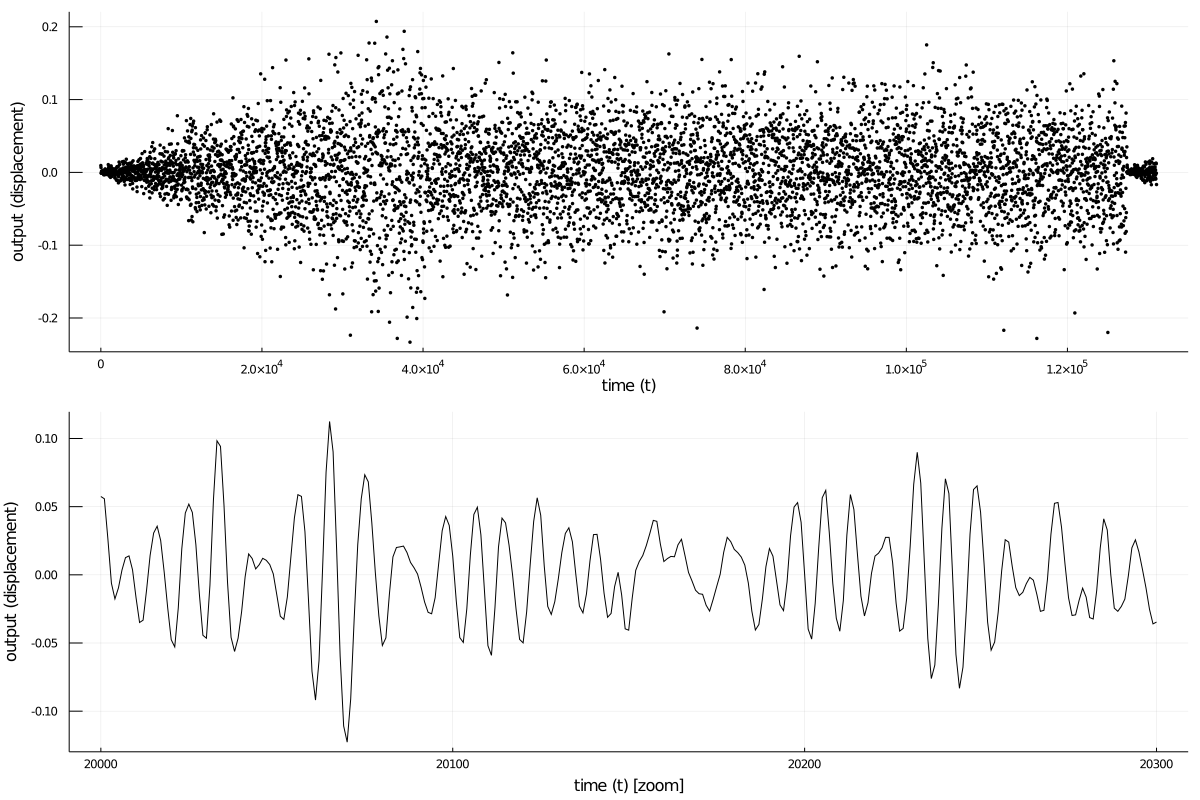

In [4]:
if viz
    # Plot every n-th time-point to avoid figure size exploding
    n = 20
    p1a = Plots.scatter(1:n:T, output[1:n:T], color="black", label="", markersize=2, xlabel="time (t)", ylabel="output (displacement)")
    p1b = Plots.plot(20000:20300, output[20000:20300], color="black", label="", markersize=2, xlabel="time (t) [zoom]", ylabel="output (displacement)")
    p1 = plot(p1a,p1b, layout=(2,1), size=(1200,800))
#     Plots.savefig(p1, "viz/output_signal.png")
end

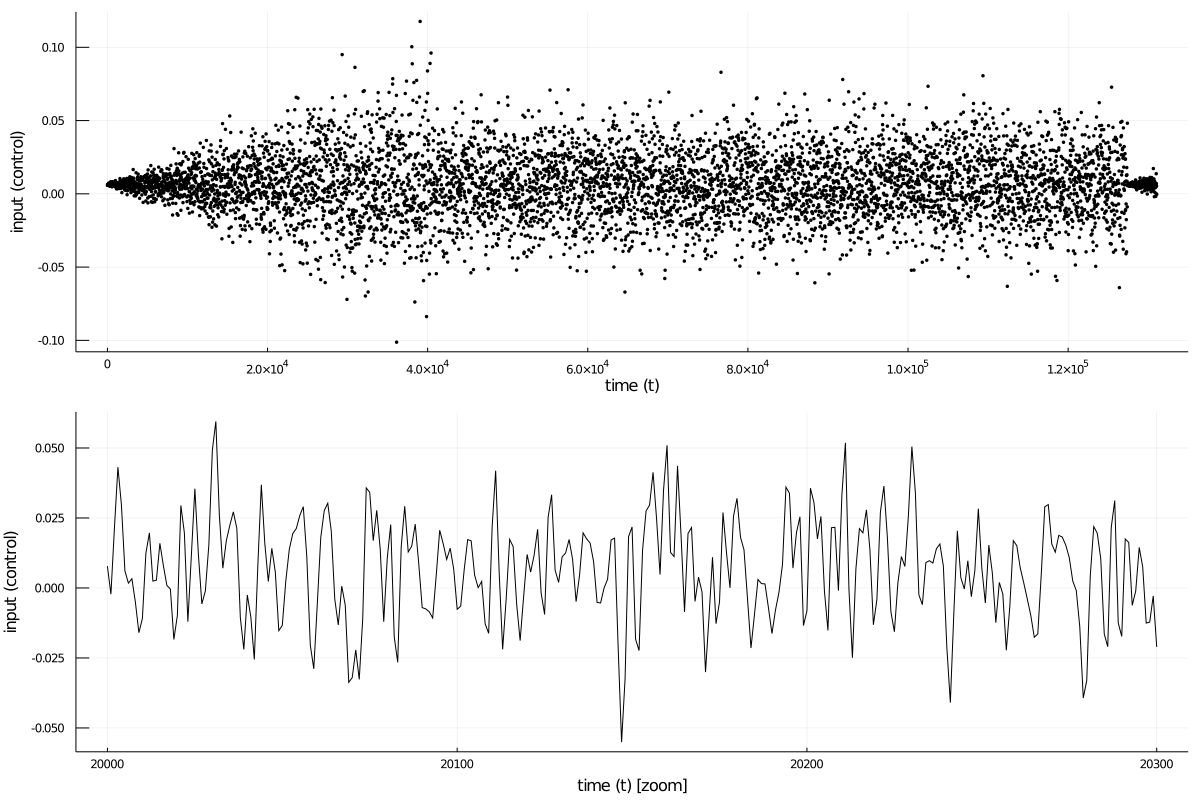

In [5]:
if viz
    # Plot every n-th time-point to avoid figure size exploding
    n = 20
    p2a = Plots.scatter(1:n:T, input[1:n:T], color="black", label="", markersize=2, xlabel="time (t)", ylabel="input (control)")
    p2b = Plots.plot(20000:20300, input[20000:20300], color="black", label="", markersize=2, xlabel="time (t) [zoom]", ylabel="input (control)")
    p2 = plot(p2a,p2b, layout=(2,1), size=(1200,800))
#     Plots.savefig(p2, "viz/input_signal.png")
end

## Estimating parameters via Bayesian filtering

Implementation with ForneyLab and AR node. The AR node is locally modified from the package LAR (LAR is in dev mode). It now contains an AutoregressiveControlNL node, where I can add a nonlinearity g as an argument.

The major change from a linear AR to a nonlinear AR node is in working out the expectations for $g(x,\theta)$ as opposed to $\theta^{\top}x$. There are a number of ways of doing this. I have chosen a first-order Taylor approximation:

$$ g(x,\theta) = g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}(x - m_x) + J_{\theta}(m_x, m_{\theta})^{\top}(\theta - m_{\theta}) \, ,$$

where $J_x$ denotes the partial derivative of $g$ with respect to $x$ and $J_{\theta}$ w.r.t. $\theta$. Note that our current $g$ is linear in $\theta$ and you could argue that you don't need to approximate it. However, the first-order Taylor is exact in that case. The expectations are:

#### First-order

- W.r.t. both $x$ and $\theta$:
$$\begin{align}
\mathbb{E}_{q(x),q(\theta)}[ g(x,\theta)] =&\ \mathbb{E}_{q(x),q(\theta)}[ g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}(x - m_x) + J_{\theta}(m_x, m_{\theta})^{\top}(\theta - m_{\theta}) ] \\
=&\ g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}\underbrace{\mathbb{E}_{q(x)}[(x - m_x)]}_{0} + J_{\theta}(m_x, m_{\theta})^{\top}\underbrace{\mathbb{E}_{q(\theta)}[(\theta - m_{\theta})]}_{0} \\
=&\ g(m_x, m_{\theta}) \, .
\end{align}$$

- W.r.t. $x$:
$$\begin{align}
\mathbb{E}_{q(x)}[ g(x,\theta)] =&\ \mathbb{E}_{q(x)}[ g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}(x - m_x) + J_{\theta}(m_x, m_{\theta})^{\top}(\theta - m_{\theta}) ] \\
=&\ g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}\underbrace{\mathbb{E}_{q(x)}[(x - m_x)]}_{0} + J_{\theta}(m_x, m_{\theta})^{\top}(\theta - m_{\theta}) \\
=&\ g(m_x, m_{\theta}) + J_{\theta}(m_x, m_{\theta})^{\top}(\theta - m_{\theta}) \\
\propto&\ J_{\theta}(m_x, m_{\theta})^{\top}\theta \, .
\end{align}$$

- W.r.t. $\theta$:
$$\begin{align}
\mathbb{E}_{q(x),q(\theta)}[ g(x,\theta)] =&\ \mathbb{E}_{q(x),q(\theta)}[ g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}(x - m_x) + J_{\theta}(m_x, m_{\theta})^{\top}(\theta - m_{\theta}) ] \\
=&\ g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}(x - m_x) + J_{\theta}(m_x, m_{\theta})^{\top}\underbrace{\mathbb{E}_{q(\theta)}[(\theta - m_{\theta})]}_{0} \\
=&\ g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}(x - m_x) \\
\propto&\ J_{x}(m_x, m_{\theta})^{\top}x \, .
\end{align}$$

#### Second-order

Shorthand: $g$ for $g(m_x, m_\theta)$, $J_x$ for $J_x(m_x, m_{\theta})$ and $J_{\theta}(m_x, m_{\theta})$.

- W.r.t. both $x$ and $\theta$:
$$\begin{align}
\mathbb{E}_{q(x),q(\theta)}[ g(x,\theta)^2] =&\ \mathbb{E}_{q(x),q(\theta)}[ \big( g + J_{x}^{\top}(x - m_x) + J_{\theta}^{\top}(\theta - m_{\theta}) \big)^2] \\
=&\ g^{2} + 2 g J_{x}^{\top}\underbrace{\mathbb{E}_{q(x)}[(x - m_x)]}_{0}  + 2 g J_{\theta}^{\top}\underbrace{\mathbb{E}_{q(\theta)}[(\theta - m_{\theta})]}_{0} + 2 J_{x}^{\top}\underbrace{\mathbb{E}_{q(x)}[(x - m_x)]}_{0} J_{\theta}^{\top}\underbrace{\mathbb{E}_{q(\theta)}[(\theta - m_{\theta})]}_{0} \\
&\ + J_x^{\top}\mathbb{E}_{q(x)}[(x - m_x)(x - m_x)^{\top}]J_x + J_{\theta}^{\top}\mathbb{E}_{q(\theta)}[(\theta - m_{\theta})(\theta - m_{\theta})^{\top}] J_{\theta} \\
=&\ g^{2} + J_x^{\top} V_x J_x + J_{\theta}^{\top} V_{\theta} J_{\theta} \, .
\end{align}$$

- W.r.t. $x$:
$$\begin{align}
\mathbb{E}_{q(x)}[ g(x,\theta)^2] =&\ \mathbb{E}_{q(x)}[ \big( g + J_{x}^{\top}(x - m_x) + J_{\theta}^{\top}(\theta - m_{\theta}) \big)^2] \\
=&\ g^{2} + 2 g J_{x}^{\top}\underbrace{\mathbb{E}_{q(x)}[(x - m_x)]}_{0}  + 2 g J_{\theta}^{\top}(\theta - m_{\theta}) + 2 J_{x}^{\top}\underbrace{\mathbb{E}_{q(x)}[(x - m_x)]}_{0} J_{\theta}^{\top}(\theta - m_{\theta}) \\
&\ + J_x^{\top}\mathbb{E}_{q(x)}[(x - m_x)(x - m_x)^{\top}]J_x + J_{\theta}^{\top}(\theta - m_{\theta})(\theta - m_{\theta})^{\top} J_{\theta} \\
=&\ g^{2} + 2 g J_{\theta}^{\top}(\theta - m_{\theta}) + J_{\theta}^{\top} V_{\theta} J_{\theta} + J_x^{\top} V_x J_x \\
\propto&\ (g-J_{\theta}^{\top}m_{\theta}) J_{\theta}^{\top}\theta + \theta^{\top}J_{\theta}(g - J_{\theta}^{\top}m_{\theta}) + \theta^{\top} J_{\theta} J_{\theta}^{\top} \theta \, .
\end{align}$$

- W.r.t. $\theta$:
$$\begin{align}
\mathbb{E}_{q(\theta)}[ g(x,\theta)^2] =&\ \mathbb{E}_{q(\theta)}[ \big( g + J_{x}^{\top}(x - m_x) + J_{\theta}^{\top}(\theta - m_{\theta}) \big)\big(\dots \big)^{\top}] \\
=&\ g^{2} + 2 g J_{x}^{\top}(x - m_x)  + 2 g J_{\theta}^{\top}\underbrace{\mathbb{E}_{q(\theta)}[(\theta - m_{\theta})]}_{0} + 2 J_{x}^{\top}(x - m_x) J_{\theta}^{\top}\underbrace{\mathbb{E}_{q(\theta)}[(\theta - m_{\theta})]}_{0} \\
&\ + J_x^{\top}(x - m_x)(x - m_x)^{\top}J_x + J_{\theta}^{\top}\mathbb{E}_{q(\theta)}[(\theta - m_{\theta})(\theta - m_{\theta})^{\top}] J_{\theta} \\
=&\ g^{2} + 2 g J_{x}^{\top}(x - m_x) + J_x^{\top} (x - m_x)(x - m_x)^{\top} J_x + J_{\theta}^{\top} V_{\theta} J_{\theta} \\
\propto&\ (g-J_x^{\top}m_x) J_x^{\top}x + x^{\top}J_x(g - J_x^{\top}m_x) + x^{\top} J_x J_x^{\top} x \, .
\end{align}$$


In [6]:
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
using LAR
using LAR.Node, LAR.Data
using ProgressMeter

In [7]:
# Start graph
graph = FactorGraph()

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(3,)), placeholder(:w_θ, dims=(3,3)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# Observation selection variable
c = [1, 0]

# Nonlinearity
g(x,θ) = θ[1]*x[1] + θ[2]*x[1]^3 + θ[3]*x[2]

# State prior
@RV z_t ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_t ~ AutoregressiveControlNL(θ, z_t, η, placeholder(:u_t), γ, g=g, id=:x_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot(c, x_t), ξ, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 17590575073182822743 -->
 
 17590575073182822743 
 
 placeholder_a_ξ 
 
<!-- 18422744229542601775 -->
 
 18422744229542601775 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 1911614172155381073 -->
 
 1911614172155381073 
 
 placeholder_m_θ 
 
<!-- 18422744229542601775--1911614172155381073 -->
 
 18422744229542601775--1911614172155381073 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 8254048077635007617 -->
 
 8254048077635007617 
 
 placeholder_w_θ 
 
<!-- 18422744229542601775--8254048077635007617 -->
 
 18422744229542601775--8254048077635007617 
 
 w_θ 
 1 out 
 3 w 
 
<!-- 6875426957282934796 -->
 
 6875426957282934796 
 
 dot 
 dotproduct_1 
 
<!-- 12902305569306360519 -->
 
 12902305569306360519 
 
 clamp_1 
 
<!-- 6875426957282934796--12902305569306360519 -->
 
 6875426957282934796--12902305569306360519 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 1714961403878480072 -->
 
 1714961403878480072 
 
 ARCNL 
 x_t 
 
<!-- 6875426957282934796--1714961403878480072 -->
 
 6875426957282934796--1714961403878480072 
 
 x_t 
 1 y 
 2 in1 
 
<!-- 6931216012501304191 -->
 
 6931216012501304191 
 
 placeholder_m_η 
 
<!-- 5096751615480784959 -->
 
 5096751615480784959 
 
 placeholder_w_z 
 
<!-- 10612380224089247640 -->
 
 10612380224089247640 
 
 placeholder_m_z 
 
<!-- 10998451999828030464 -->
 
 10998451999828030464 
 
 placeholder_u_t 
 
<!-- 11476911921566380659 -->
 
 11476911921566380659 
 
 𝒩 
 y_t 
 
<!-- 11476911921566380659--6875426957282934796 -->
 
 11476911921566380659--6875426957282934796 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 8205726266151833388 -->
 
 8205726266151833388 
 
 Gam 
 gamma_2 
 
<!-- 11476911921566380659--8205726266151833388 -->
 
 11476911921566380659--8205726266151833388 
 
 ξ 
 1 out 
 3 w 
 
<!-- 5471608931466699179 -->
 
 5471608931466699179 
 
 placeholder_b_γ 
 
<!-- 12900336517156560124 -->
 
 12900336517156560124 
 
 placeholder_w_η 
 
<!-- 18442631078774709043 -->
 
 18442631078774709043 
 
 placeholder_a_γ 
 
<!-- 2651557560914572252 -->
 
 2651557560914572252 
 
 𝒩 
 z_t 
 
<!-- 2651557560914572252--5096751615480784959 -->
 
 2651557560914572252--5096751615480784959 
 
 w_z 
 1 out 
 3 w 
 
<!-- 2651557560914572252--10612380224089247640 -->
 
 2651557560914572252--10612380224089247640 
 
 m_z 
 1 out 
 2 m 
 
<!-- 9430991818238546426 -->
 
 9430991818238546426 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 9430991818238546426--6931216012501304191 -->
 
 9430991818238546426--6931216012501304191 
 
 m_η 
 1 out 
 2 m 
 
<!-- 9430991818238546426--12900336517156560124 -->
 
 9430991818238546426--12900336517156560124 
 
 w_η 
 1 out 
 3 w 
 
<!-- 15748776198808916372 -->
 
 15748776198808916372 
 
 placeholder_y_t 
 
<!-- 15748776198808916372--11476911921566380659 -->
 
 15748776198808916372--11476911921566380659 
 
 y_t 
 1 out 
 1 out 
 
<!-- 14178300648222761562 -->
 
 14178300648222761562 
 
 Gam 
 gamma_1 
 
<!-- 14178300648222761562--5471608931466699179 -->
 
 14178300648222761562--5471608931466699179 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 14178300648222761562--18442631078774709043 -->
 
 14178300648222761562--18442631078774709043 
 
 a_γ 
 1 out 
 2 a 
 
<!-- 1714961403878480072--18422744229542601775 -->
 
 1714961403878480072--18422744229542601775 
 
 θ 
 1 out 
 3 θ 
 
<!-- 1714961403878480072--10998451999828030464 -->
 
 1714961403878480072--10998451999828030464 
 
 u_t 
 1 out 
 5 u 
 
<!-- 1714961403878480072--2651557560914572252 -->
 
 1714961403878480072--2651557560914572252 
 
 z_t 
 1 out 
 2 x 
 
<!-- 1714961403878480072--9430991818238546426 -->
 
 1714961403878480072--9430991818238546426 
 
 η 
 1 out 
 4 η 
 
<!-- 1714961403878480072--14178300648222761562 -->
 
 1714961403878480072--14178300648222761562 
 
 γ 
 1 out 
 6 γ 
 
<!-- 8205726266151833388--17590575073182822743 -->


In [8]:
# Infer an algorithm
q = PosteriorFactorization(z_t, x_t, θ, η, γ, ξ, ids=[:z, :x, :θ, :η, :γ, :ξ])
algo = variationalAlgorithm(q, free_energy=false)
source_code = algorithmSourceCode(algo, free_energy=false)
eval(Meta.parse(source_code));
# println(source_code)

In [9]:
# Looking at only the first few timepoints
# T = 100
T = size(df, 1);

# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_x = (zeros(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_θ = (ones(3,T+1), repeat(.1 .*float(eye(3)), outer=(1,1,T+1)))
params_η = (ones(1,T+1), 0.1*ones(1,T+1))
params_γ = (0.01*ones(1,T+1), 0.01*ones(1,T+1))
params_ξ = (1e5*ones(1,T+1), 1e1*ones(1,T+1))

# Start progress bar
p = Progress(T, 1, "At time ")

# Perform inference at each time-step
for t = 1:T

    # Update progress bar
    update!(p, t)

    # Initialize marginals
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t], w=params_η[2][1,t])
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t], b=params_γ[2][1,t])
    marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=params_ξ[1][1,t], b=params_ξ[2][1,t])
    
    data = Dict(:y_t => output[t],
                :u_t => input[t],
                :m_z => params_x[1][:,t],
                :w_z => params_x[2][:,:,t],
                :m_θ => params_θ[1][:,t],
                :w_θ => params_θ[2][:,:,t],
                :m_η => params_η[1][1,t],
                :w_η => params_η[2][1,t],
                :a_γ => params_γ[1][1,t],
                :b_γ => params_γ[2][1,t],
                :a_ξ => params_ξ[1][1,t],
                :b_ξ => params_ξ[2][1,t])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepx!(data, marginals)
        stepθ!(data, marginals)
        stepη!(data, marginals)
        stepγ!(data, marginals)
        stepξ!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_x[1][:,t+1] = unsafeMean(marginals[:x_t])
    params_x[2][:,:,t+1] = marginals[:x_t].params[:w]
    params_θ[1][:,t+1] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,t+1] = marginals[:θ].params[:w]
    params_η[1][1,t+1] = unsafeMean(marginals[:η])
    params_η[2][1,t+1] = marginals[:η].params[:w]
    params_γ[1][1,t+1] = marginals[:γ].params[:a]
    params_γ[2][1,t+1] = marginals[:γ].params[:b]
    params_ξ[1][1,t+1] = marginals[:ξ].params[:a]
    params_ξ[2][1,t+1] = marginals[:ξ].params[:b]

end

At time 100%|███████████████████████████████████████████| Time: 0:04:348:22


### Visualize results

In [10]:
# Extract mean of state marginals
estimated_states = params_x[1][1,2:end]

if viz
    # Plot every n-th time-point to avoid figure size exploding
    n = 10
    p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1200,600), xlabel="time (t)", ylabel="response")
    Plots.plot!(1:n:T, estimated_states[1:n:T], color="red", linewidth=1, label="estimated")
#     Plots.savefig(p1, "viz/nonlin_estimated_states01.png")
end

In [11]:
# Extract mean of coefficient marginals
estimated_θ1_mean = params_θ[1][1,2:end]
estimated_θ2_mean = params_θ[1][2,2:end]
estimated_θ3_mean = params_θ[1][3,2:end]
estimated_θ1_std = sqrt.(inv.(params_θ[2][1,1,2:end]))
estimated_θ2_std = sqrt.(inv.(params_θ[2][2,2,2:end]))
estimated_θ3_std = sqrt.(inv.(params_θ[2][3,3,2:end]))

if viz
    
    # Plot both coefficients next to each other
    p2a = Plots.plot(1:n:T, estimated_θ1_mean[1:n:T], ribbon=[estimated_θ1_std[1:n:T], estimated_θ1_std[1:n:T]], color="red", label="θ_1", xlabel="time (t)")
    p2b = Plots.plot(1:n:T, estimated_θ2_mean[1:n:T], ribbon=[estimated_θ2_std[1:n:T], estimated_θ2_std[1:n:T]], color="blue", label="θ_2", xlabel="time (t)")
    p2c = Plots.plot(1:n:T, estimated_θ3_mean[1:n:T], ribbon=[estimated_θ3_std[1:n:T], estimated_θ3_std[1:n:T]], color="green", label="θ_3", xlabel="time (t)")
    p2 = plot(p2a, p2b, p2c, layout=(3,1), size=(800,1200))
#     Plots.savefig(p2, "viz/nonlin_estimated_θ.png")
end

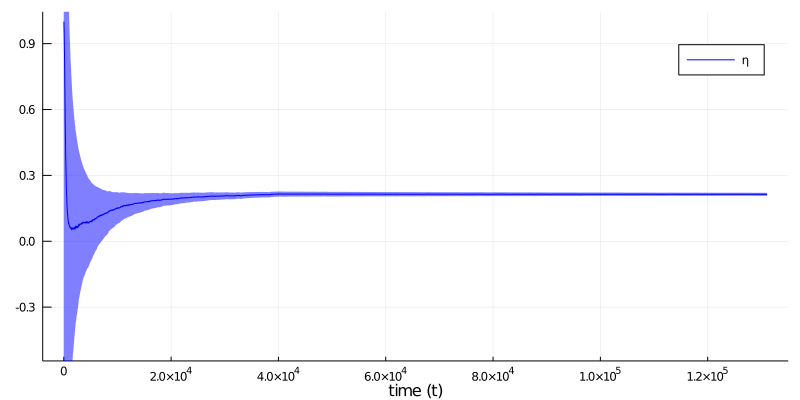

In [12]:
# Extract mean of control coefficient marginals
estimated_η_mean = params_η[1][1,2:end]
estimated_η_std = sqrt.(inv.(params_η[2][1,2:end]))

if viz
    # Plot both coefficients next to each other
    p3 = Plots.plot(1:n:T, estimated_η_mean[1:n:T], ribbon=[estimated_η_std[1:n:T], estimated_η_std[1:n:T]], color="blue", label="η", xlabel="time (t)", ylim=[-.5, 1.], size=(800,400))
#     Plots.savefig(p3, "viz/nonlin_estimated_η.png")
end

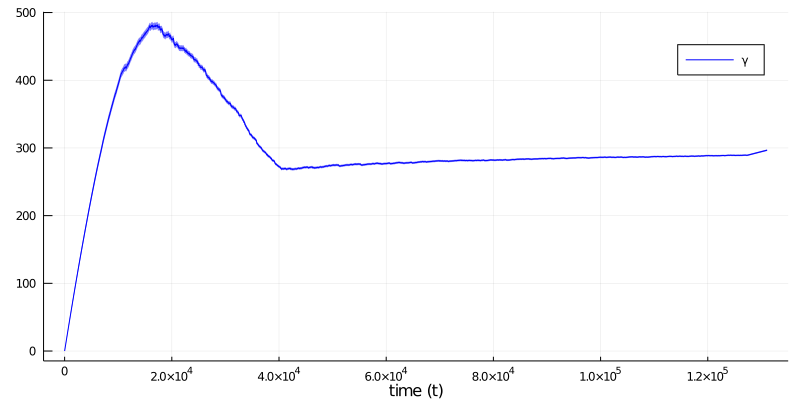

In [13]:
# Extract mean of process precision marginals
estimated_γ_mean = params_γ[1][1,2:end] ./ params_γ[2][1,2:end]
estimated_γ_std = sqrt.(params_γ[1][1,2:end] ./ params_γ[2][1,2:end].^2)

if viz
    # Plot both coefficients next to each other
    p4 = Plots.plot(1:n:T, estimated_γ_mean[1:n:T], ribbon=[estimated_γ_std[1:n:T], estimated_γ_std[1:n:T]], color="blue", label="γ", xlabel="time (t)", size=(800,400))
#     Plots.savefig(p4, "viz/nonlin_estimated_γ.png")
end

In [14]:
# Extract mean of measurement precision marginals
estimated_ξ_mean = params_ξ[1][1,2:end] ./ params_ξ[2][1,2:end]
estimated_ξ_std = sqrt.(params_ξ[1][1,2:end] ./ params_ξ[2][1,2:end].^2)

if viz
    # Plot both coefficients next to each other
    p8 = Plots.plot(1:n:T, estimated_ξ_mean[1:n:T], ribbon=[estimated_ξ_std[1:n:T], estimated_ξ_std[1:n:T]], color="blue", label="measurement-precision", xlabel="time (t)", size=(600,400), legend=:bottomright)
    Plots.savefig(p8, "viz/nonlin_estimated_measurement-precision_600x400.png")
end

## Solving nonlinear system of equations

We currently have estimates for $\theta_1$, $\theta_2$, $\theta_3$, $\eta$ and $\gamma^{-1}$. But we want to know the original coefficients, $m$, $v$, $a$ and $b$, which actually have a physical meaning. To obtain estimates for those, we have to solve the following nonlinear system of equations:

$$\begin{align} 
\hat{\theta}_1 =&\ \frac{2m + v - a}{m + v} \\
\hat{\theta}_2 =&\ \frac{-b}{m + v} \\
\hat{\theta}_3 =&\ \frac{-m}{m + v} \\
\hat{\eta} =&\ \frac{1}{m + v} \\
\hat{\gamma}^{-1} =&\ \frac{1}{\tau (m + v)^2}
\end{align}$$

We first move the LHS to the right and then solve for the system equating the null-vector.

In [15]:
using NLsolve

In [16]:
# Current estimates of parameters
estimates = [estimated_θ1_mean[end], estimated_θ2_mean[end], estimated_θ3_mean[end], estimated_η_mean[end], inv(estimated_γ_mean[end])]

5-element Array{Float64,1}:
  1.515202963726804
 -1.4530903353125317
 -0.9671042002849626
  0.21369183250742582
  0.003370787120973221

In [17]:
# Define nonlinear system of equations
function F!(F, x)
    F[1] = (2*x[1] + x[2] - x[3])/(x[1] + x[2])  - estimates[1]
    F[2] = (-x[4])/(x[1] + x[2]) - estimates[2]
    F[3] = (-x[1])/(x[1] + x[2]) - estimates[3]
    F[4] = 1/(x[1] + x[2]) - estimates[4]
    F[5] = 1/(x[5]*(x[1] + x[2])^2) - estimates[5] 
end

# Call solver
x_solved = nlsolve(F!, [1. 1. 1. 1. 1.], autodiff=:forward)

# Extract new estimates
m, v, a, b, τ = x_solved.zero

1×5 Array{Float64,2}:
 4.5257  0.15394  2.11473  6.79993  13.547

So, in total we estimate the dynamical parameters as follows:

In [18]:
println("m = " *string(m))
println("v = " *string(v))
println("a = " *string(a))
println("b = " *string(b))
println("τ = " *string(τ))

m = 4.525695666217639
v = 0.1539403697794316
a = 2.114733311309196
b = 6.79993389668759
τ = 13.547042408672953


Now, I'm going to estimate the dynamical parameters for the entire trajectory. Note that I could do this at inference time as well.

In [19]:
mass = zeros(T,1)
friction = zeros(T,1)
stiffness_a = zeros(T,1)
stiffness_b = zeros(T,1)
process_precision = zeros(T,1)

# Extract means of marginals
estimated_θ1 = params_θ[1][1,2:end]
estimated_θ2 = params_θ[1][2,2:end]
estimated_θ3 = params_θ[1][3,2:end]
estimated_η = params_η[1][1,2:end]
estimated_γ = inv.(params_γ[1][1,2:end] ./ params_γ[2][1,2:end])

for t = 1:T
    
    function F!(F, x)
        F[1] = (2*x[1] + x[2] - x[3])/(x[1] + x[2])  - estimated_θ1[t]
        F[2] = (-x[4])/(x[1] + x[2]) - estimated_θ2[t]
        F[3] = (-x[1])/(x[1] + x[2]) - estimated_θ3[t]
        F[4] = 1/(x[1] + x[2]) - estimated_η[t]
        F[5] = 1/(x[5]*(x[1] + x[2])^2) - estimated_γ[t] 
    end
    
    # Call solver
#     x_solved = nlsolve(F!, J!, [1. 1. 1. 1.])
    x_solved = nlsolve(F!, [1. 1. 1. 1. 1.], autodiff=:forward)

    # Extract new estimates
    mass[t], friction[t], stiffness_a[t], stiffness_b[t], process_precision[t] = x_solved.zero
    
end

In [25]:
# Plot belief evolution for mass
p9 = Plots.plot(1:n:T, mass[1:n:T], color="red", label="mass", linewidth=2, xlabel="time (t)", size=(600,400))
Plots.savefig(p9, "viz/nonlin_estimated_mass_600x400.png")

In [26]:
# Plot belief evolution for friction coefficient
p10 = Plots.plot(1:n:T, friction[1:n:T], color="blue", linewidth=2, label="friction", xlabel="time (t)", size=(600,400))
Plots.savefig(p10, "viz/nonlin_estimated_friction_600x400.png")

In [27]:
# Plot belief evolution for linear stiffness
p11 = Plots.plot(1:n:T, stiffness_a[1:n:T], color="green", linewidth=2, label="spring stiffness", xlabel="time (t)", size=(600,400))
Plots.savefig(p11, "viz/nonlin_estimated_stiffness-a_600x400.png")

In [28]:
# Plot belief evolution for nonlinear stiffness
p12 = Plots.plot(1:n:T, stiffness_b[1:n:T], color="green", label="stiffness_b", xlabel="time (t)", size=(600,400))
Plots.savefig(p12, "viz/nonlin_estimated_stiffness-b_600x400.png")

In [29]:
# Plot belief evolution for process precision
p13 = Plots.plot(1:n:T, process_precision[1:n:T], color="purple", label="process_precision", xlabel="time (t)", size=(600,400))
Plots.savefig(p13, "viz/nonlin_estimated_process-precision_600x400.png")